In [1]:
# in this code i am using 10% of blind well for fine tunning. its results are best so far.
# next step i will text with 15%
# i will test adding layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from sklearn.model_selection import train_test_split
import csv

print("✅ Libraries loaded.")


/Users/IDEAPAD/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


✅ Libraries loaded.


In [2]:

blind_labeled_file = 'MISSA KESWAL-02.CSV'
delim = ','
df_blind = pd.read_csv(blind_labeled_file, delimiter=delim)
df_blind.columns = df_blind.columns.str.strip().str.lower()
df_blind.replace(-999.25, np.nan, inplace=True)

features = ['gr', 'dt', 'dt_nct', 'rhob_combined', 'res_deep', 'sphi', 'hp', 'ob']
depth_col = 'depth'
target_col = 'ppp'

df_blind.dropna(subset=features + [depth_col, target_col], inplace=True)
df_finetune, df_blind_val = train_test_split(df_blind, test_size=0.9, random_state=42)

print(f"✅ Fine-tuning samples: {len(df_finetune)} | Validation samples: {len(df_blind_val)}")


✅ Fine-tuning samples: 519 | Validation samples: 4671


In [3]:

scaler = StandardScaler()
X_finetune = scaler.fit_transform(df_finetune[features])
y_finetune = df_finetune[target_col].values
X_val = scaler.transform(df_blind_val[features])
y_val = df_blind_val[target_col].values

X_finetune_cnn = X_finetune.reshape((X_finetune.shape[0], X_finetune.shape[1], 1))
X_val_cnn = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

print("✅ Data scaled and reshaped.")


✅ Data scaled and reshaped.


In [4]:
model_path = '/Users/IDEAPAD/Documents/Research work/Geoscience project/Well Data/PPCNN/cnn_model.h5'
cnn = load_model(model_path, compile=False)

cnn.compile(optimizer='adam', loss=MeanSquaredError())

cnn_finetuned = clone_model(cnn)
cnn_finetuned.set_weights(cnn.get_weights())
cnn_finetuned.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

cnn_finetuned.fit(X_finetune_cnn, y_finetune,
                  validation_data=(X_val_cnn, y_val),
                  epochs=100,
                  batch_size=16,
                  callbacks=[early_stop, reduce_lr],
                  verbose=1)

print("✅ CNN fine-tuning complete.")


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 730365.5625 - val_loss: 420878.4062 - learning_rate: 0.0010
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 521541.1250 - val_loss: 339400.4688 - learning_rate: 0.0010
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 380361.3125 - val_loss: 326316.8438 - learning_rate: 0.0010
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 328562.8438 - val_loss: 303377.6562 - learning_rate: 0.0010
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 394202.7500 - val_loss: 282995.3125 - learning_rate: 0.0010
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 333916.5625 - val_loss: 272417.6562 - learning_rate: 0.0010
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 350026.5938 - val_loss: 272225.9688 - learning_rate: 0.0010
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 384789.0000 - val_loss: 263606.0938 - learning_rate: 0.0010
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/st

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
📊 CNN (Fine-Tuned on Blind Well):
   R²     : 0.6801
   MSE    : 196738.20
   RMSE   : 443.55
   MAE    : 331.61
   Rel RMSE: 11.16% of PPP range



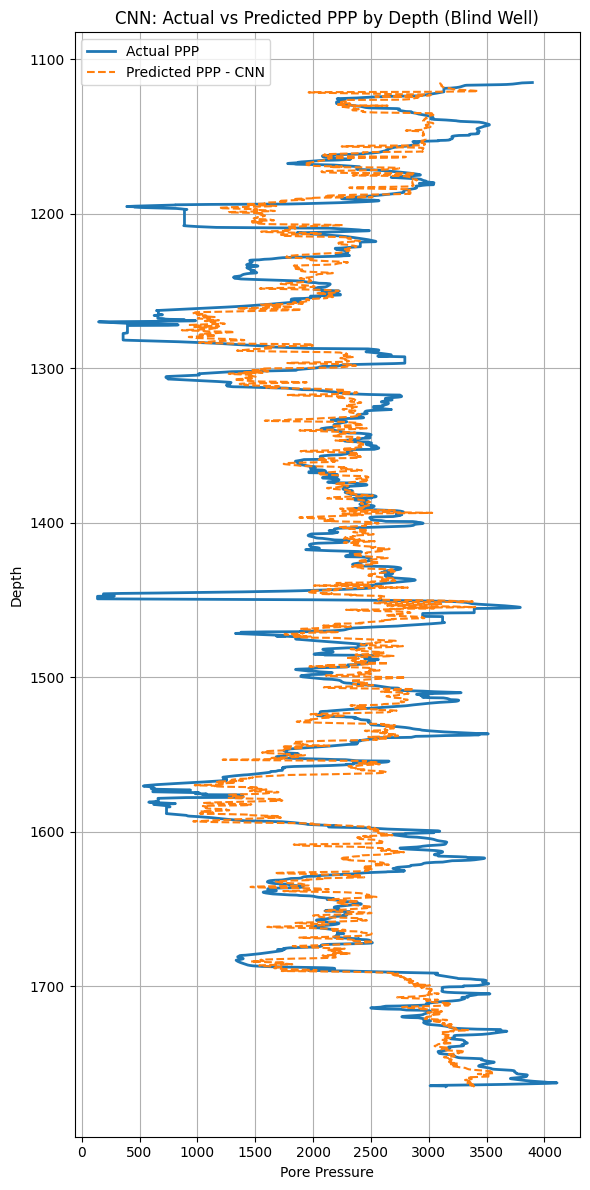

In [5]:

y_pred_val_cnn = cnn_finetuned.predict(X_val_cnn).flatten()

def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    rel_rmse = (rmse / (max(y_true) - min(y_true))) * 100
    print(f"📊 {name}:")
    print(f"   R²     : {r2:.4f}")
    print(f"   MSE    : {mse:.2f}")
    print(f"   RMSE   : {rmse:.2f}")
    print(f"   MAE    : {mae:.2f}")
    print(f"   Rel RMSE: {rel_rmse:.2f}% of PPP range\n")

evaluate_model("CNN (Fine-Tuned on Blind Well)", y_val, y_pred_val_cnn)

# Plot
depth_val = df_blind_val[depth_col].values
sorted_idx = np.argsort(depth_val)
plt.figure(figsize=(6, 12))
plt.plot(y_val[sorted_idx], depth_val[sorted_idx], label='Actual PPP', linewidth=2)
plt.plot(y_pred_val_cnn[sorted_idx], depth_val[sorted_idx], label='Predicted PPP - CNN', linestyle='--')
plt.gca().invert_yaxis()
plt.xlabel('Pore Pressure')
plt.ylabel('Depth')
plt.title('CNN: Actual vs Predicted PPP by Depth (Blind Well)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
# Load and clone DFNN model
model_path = '/Users/IDEAPAD/Documents/Research work/Geoscience project/Well Data/PPCNN/dfnn_model.h5'
dfnn = load_model(model_path, compile=False)

dfnn.compile(optimizer='adam', loss=MeanSquaredError())

dfnn_finetuned = clone_model(dfnn)
dfnn_finetuned.set_weights(dfnn.get_weights())
dfnn_finetuned.compile(optimizer='adam', loss='mse')


In [7]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Train on 10% blind well
dfnn_finetuned.fit(X_finetune, y_finetune,
                   validation_data=(X_val, y_val),
                   epochs=100,
                   batch_size=16,
                   callbacks=[early_stop, reduce_lr],
                   verbose=1)

print("✅ DFNN fine-tuning complete.")

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1127951.8750 - val_loss: 795300.5000 - learning_rate: 0.0010
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 808939.3750 - val_loss: 677427.2500 - learning_rate: 0.0010
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 632672.8750 - val_loss: 605177.6875 - learning_rate: 0.0010
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 591390.2500 - val_loss: 556081.5625 - learning_rate: 0.0010
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 529429.2500 - val_loss: 501721.9062 - learning_rate: 0.0010
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 617809.8125 - val_loss: 468002.6250 - learning_rate: 0.0010
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 490160.1875 - val_loss: 432069.7812 - learning_rate: 0.0010
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 509858.4688 - val_loss: 404468.5312 - learning_rate: 0.0010
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/s

In [8]:
# Predict and evaluate
y_pred_val_dfnn = dfnn_finetuned.predict(X_val).flatten()

def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    rel_rmse = (rmse / (max(y_true) - min(y_true))) * 100
    print(f"📊 {name}:")
    print(f"   R²     : {r2:.4f}")
    print(f"   MSE    : {mse:.2f}")
    print(f"   RMSE   : {rmse:.2f}")
    print(f"   MAE    : {mae:.2f}")
    print(f"   Rel RMSE: {rel_rmse:.2f}% of PPP range\n")

evaluate_model("DFNN (Fine-Tuned on Blind Well)", y_val, y_pred_val_dfnn)

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
📊 DFNN (Fine-Tuned on Blind Well):
   R²     : 0.6757
   MSE    : 199441.29
   RMSE   : 446.59
   MAE    : 333.32
   Rel RMSE: 11.24% of PPP range



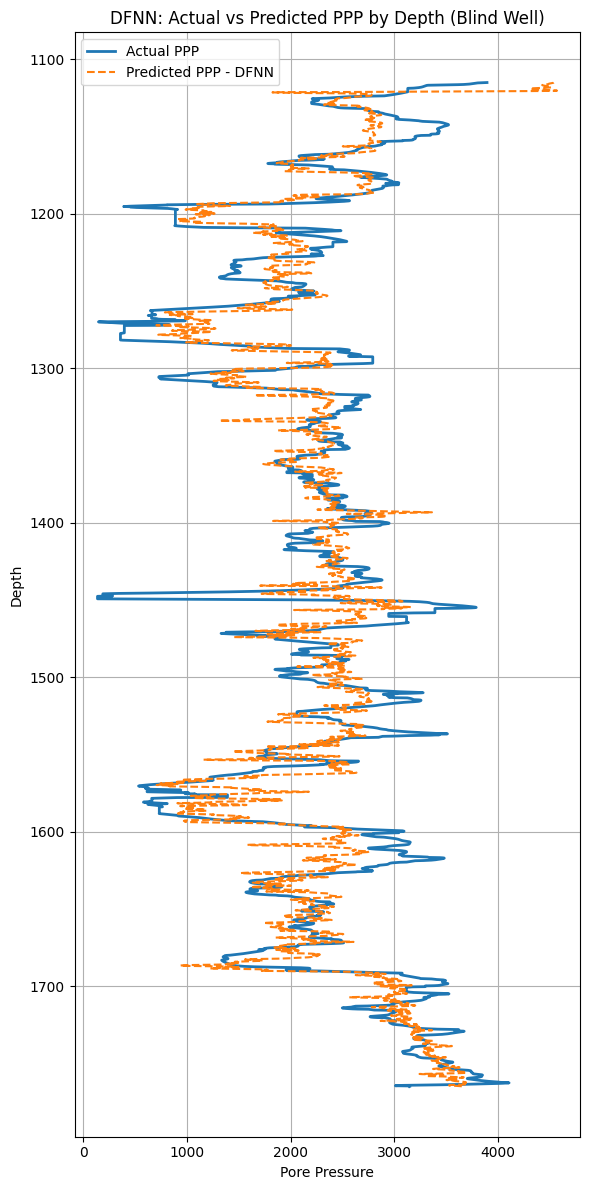

In [9]:
# Plot
depth_val = df_blind_val[depth_col].values
sorted_idx = np.argsort(depth_val)
plt.figure(figsize=(6, 12))
plt.plot(y_val[sorted_idx], depth_val[sorted_idx], label='Actual PPP', linewidth=2)
plt.plot(y_pred_val_dfnn[sorted_idx], depth_val[sorted_idx], label='Predicted PPP - DFNN', linestyle='--')
plt.gca().invert_yaxis()
plt.xlabel('Pore Pressure')
plt.ylabel('Depth')
plt.title('DFNN: Actual vs Predicted PPP by Depth (Blind Well)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()